In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import packages
import numpy as np
import os
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import pandas as pd
import json

# Local imports
from src.lstm_2.model_generation.helper_methods import generate_data, order_features_config
from src.data_processing.lstm_data_preprocessing import FeaturesConfig


In [ ]:
# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

# Empty dictionary to hold all models
models = {}

# Create placeholder variable names (or models if already trained)
batch_sizes = [16, 32, 64, 128, 256]

for feature_set in range(1, 4):  # 1 to 3
    for batch_size in batch_sizes:
        model_folder = f"../model_generation/trained_models/lstm_{feature_set}_{batch_size}"
        model_name = f"model_{feature_set}_{batch_size}"
        with open(os.path.join(model_folder, "config.json"), 'r') as f:
            configs = json.load(f)
        features_config = configs["features_config"]
        time_bucket_folder = configs["time_bucket_folder"]
        test_size = configs["test_size"]
        model = load_model(os.path.join(model_folder, "model.keras"),
            custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
        models[model_name] = {"model": model, "feature_config": features_config, "time_bucket_folder": time_bucket_folder, "test_size": test_size}

In [ ]:
# 1. Get unique feature config / time bucket / test size combinations
unique_configs = set()

for model_info in models.values():
    config_key = (
        tuple(model_info["feature_config"].items()),
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )
    unique_configs.add(config_key)

# 2. Generate datasets once per unique config
datasets = {}

for config in unique_configs:
    features_config, time_bucket_folder, test_size = config
    
    # Rebuild dict to then use in order_features_config method to get ordered list of boolean values for features
    ordered_features_config = order_features_config(dict(features_config))

    # Create FeaturesConfig object
    features_config = FeaturesConfig(*ordered_features_config)

    # Generate / load data
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = generate_data(
        features_config=features_config,
        time_bucket_folder=time_bucket_folder,
        test_size=test_size
    )

    datasets[config] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_scaler": X_scaler,
        "y_scaler": y_scaler
    }


In [ ]:
model_results = {}

for model_name, model_info in models.items():
    # Rebuild the config_key using the tuple of (key, value) pairs for feature_config
    config_key = (
        tuple(model_info["feature_config"].items()),  # <-- Ensure feature_config is a tuple of (key, value)
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )

    # Fetch the corresponding data from datasets using the correct config_key
    data = datasets[config_key]

    X_test = data["X_test"]
    y_test = data["y_test"]
    model = model_info["model"]

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform to get real values
    y_pred_actual = data["y_scaler"].inverse_transform(y_pred)
    y_test_actual = data["y_scaler"].inverse_transform(y_test)

    # Save the predictions and actual values in model_results
    model_results[model_name] = {"pred": y_pred_actual, "real": y_test_actual}


In [ ]:
import pickle

# Save model_results to a file
with open("all_model_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

print("model_results saved successfully!")


In [1]:
# Load results
import pickle

with open("all_model_results.pkl", "rb") as f:
    model_results = pickle.load(f)

In [2]:
from metrics_methods import get_model_comparison

model_comparison = get_model_comparison(model_results, threshold=1.5)

In [ ]:
from visualisation_methods import plot_multiple_model_results_old


plot_multiple_model_results_old(model_comparison)

c:\Users\matth\Uni Work\CM3203 - Individual Project\Project Environment\CM3203-Individual-Project\src\lstm_2\model_testing\visualisation_methods.py:341: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusted to give more space for the title


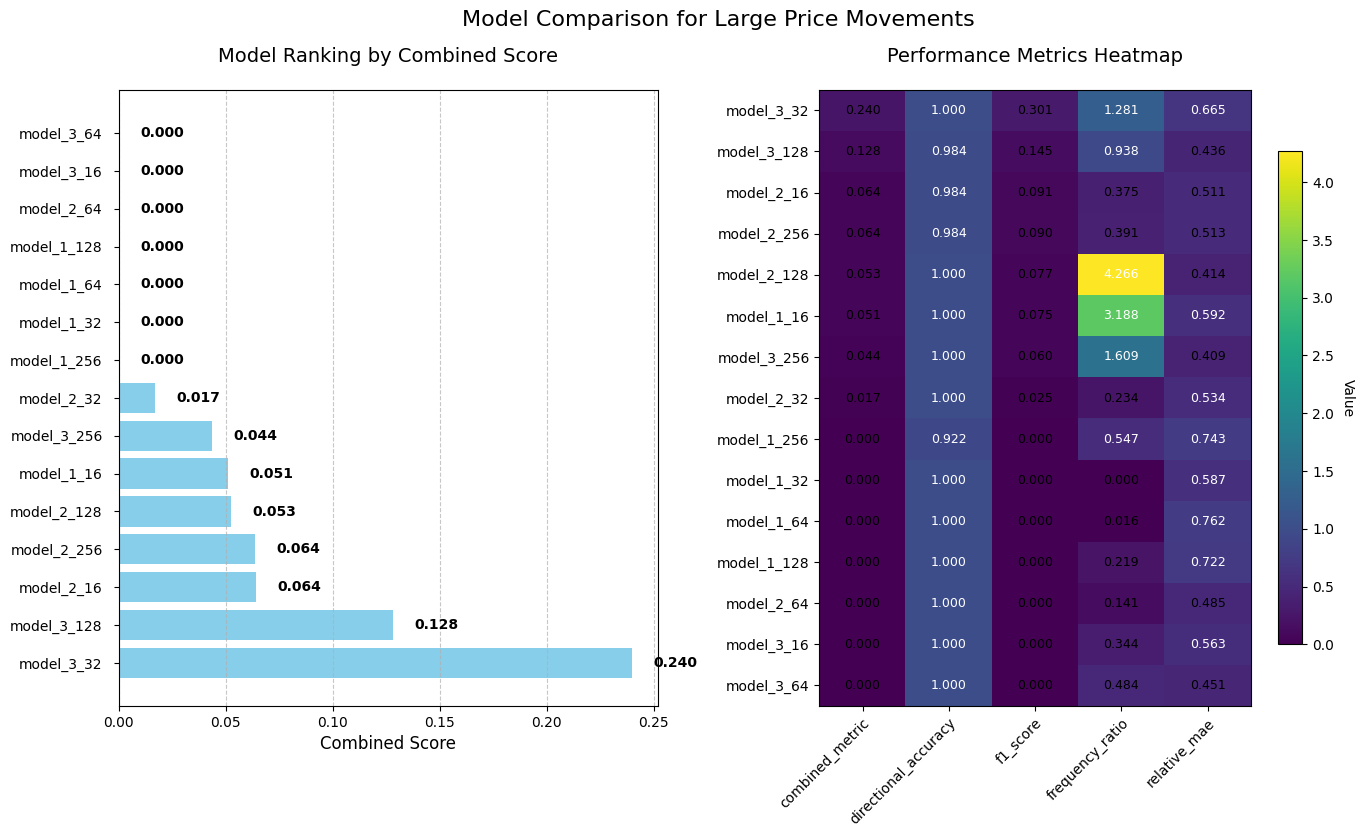

c:\Users\matth\Uni Work\CM3203 - Individual Project\Project Environment\CM3203-Individual-Project\src\lstm_2\model_testing\visualisation_methods.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusted to give more space for the title


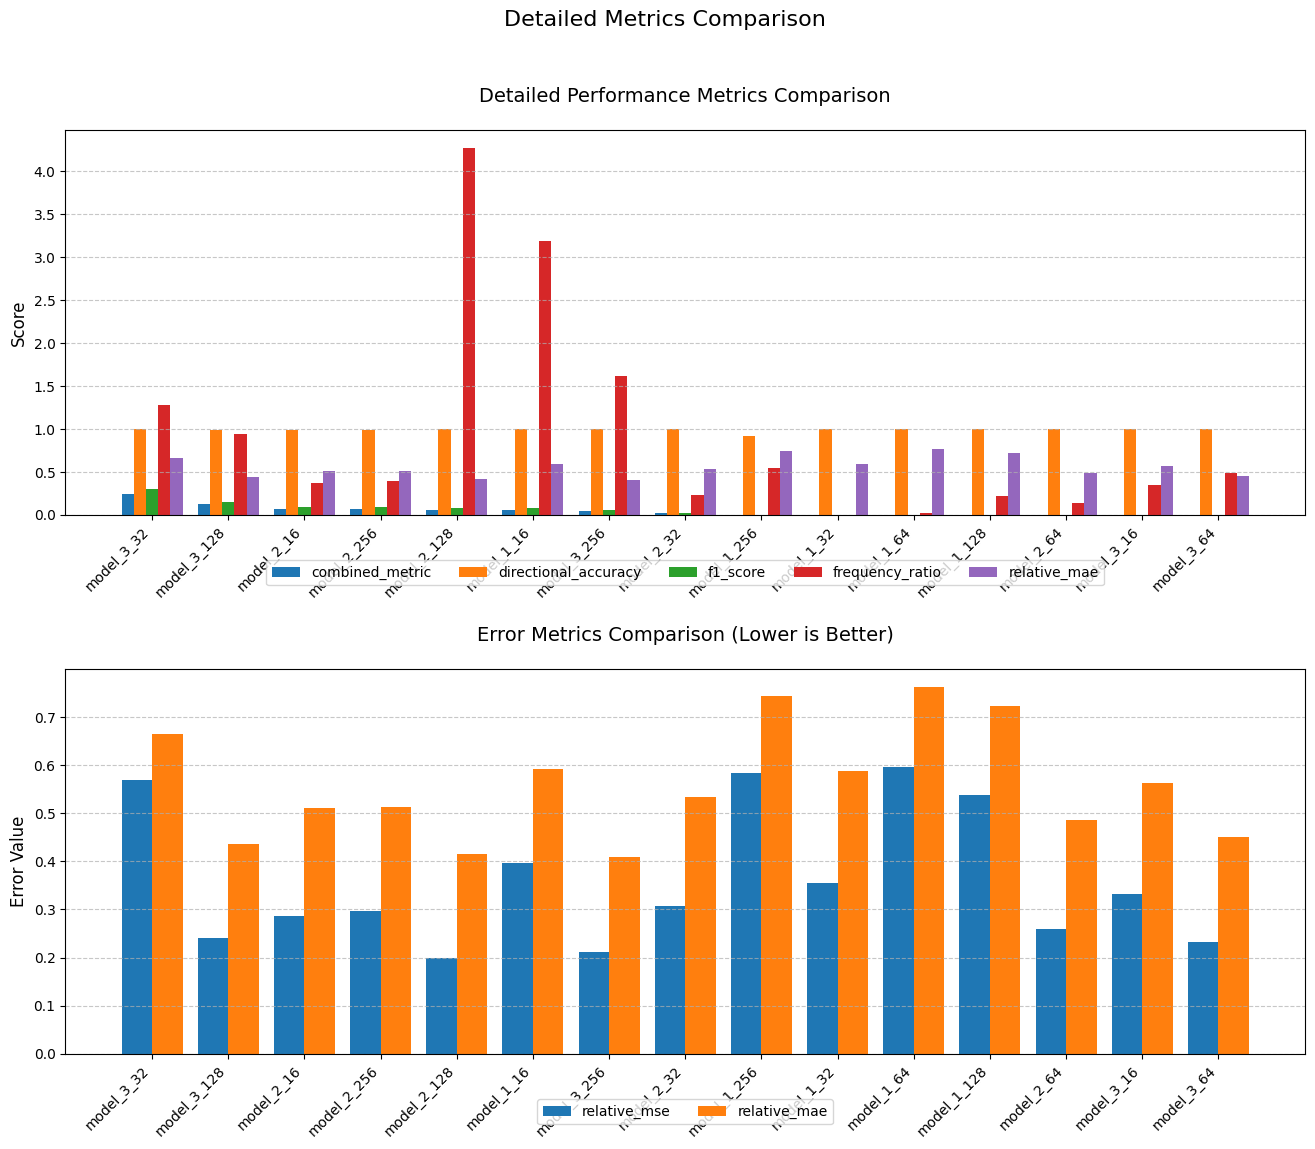

In [3]:
from visualisation_methods import plot_model_comparison

plot_model_comparison(model_comparison)